In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset, DatasetDict
import evaluate

import torch
import torch.nn as nn
import torch.nn.functional as F
from safetensors.torch import load_file

import math
import numpy as np

from dataclasses import dataclass

from transformers import Trainer, TrainingArguments, AutoTokenizer, DataCollatorForLanguageModeling

from huggingface_hub import notebook_login

In [3]:
tokenizer = AutoTokenizer.from_pretrained("unsloth/Meta-Llama-3.1-8B-Instruct")

In [4]:
@dataclass
class Config:
    d_model: int = 512
    d_ff: int = 2048
    n_heads: int = 8
    vocab_size: int = len(tokenizer)

In [5]:
class PositionalEmbedding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """

        x = x + self.pe[:x.size(1)].unsqueeze(0)
        return self.dropout(x)

class LayerAttention(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.n_heads = config.n_heads

        assert config.d_model % self.n_heads == 0, "d_model should be divisible by n_heads"

        self.d_k = config.d_model // self.n_heads

        self.w_q = nn.Linear(config.d_model, config.d_model)
        self.w_k = nn.Linear(config.d_model, config.d_model)
        self.w_v = nn.Linear(config.d_model, config.d_model)
        self.w_o = nn.Linear(config.d_model, config.d_model)

    def forward(self, query, key, value, attention_mask=None, return_attn=False):
        bs, seq_len = query.size(0), query.size(1)
        
        # Q, K, V
        q = self.w_q(query)
        k = self.w_k(key)
        v = self.w_v(value)
    
        q = q.view(bs, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(bs, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(bs, seq_len, self.n_heads, self.d_k).transpose(1, 2)
    
        # QK^T
        qk = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
    
        # === MASKING ===
        causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=query.device)).bool()
        causal_mask = ~causal_mask  # True = запрет
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, seq_len]
    
        if attention_mask is not None:
            pad_mask = attention_mask.unsqueeze(1).unsqueeze(2) == 0  # [batch, 1, 1, seq_len]
            full_mask = pad_mask | causal_mask
        else:
            full_mask = causal_mask
    
        qk = qk.masked_fill_(full_mask, torch.finfo(qk.dtype).min)
    
        # === ATTENTION ===
        attn_scores = qk.softmax(-1)
        attn_values = attn_scores @ v
        output = attn_values.transpose(1, 2).reshape(bs, seq_len, -1)
        output = self.w_o(output)
    
        if return_attn:
            return output, attn_scores
        return output




class AtAtModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.d_model)
        self.attn1 = LayerAttention(config)
        self.attn2 = LayerAttention(config)
        self.unembed = nn.Linear(config.d_model, config.vocab_size)
        self.criterion = nn.CrossEntropyLoss()
        self.pe = PositionalEmbedding(config.d_model)

    def get_attention(self, input_ids, attention_mask=None):
        x = self.embed(input_ids)
        x1, attn1 = self.attn1(x, x, x, attention_mask, return_attn=True)
        x2, attn2 = self.attn2(x + x1, x + x1, x + x1, attention_mask, return_attn=True)
        return attn1, attn2

    def forward(self, input_ids, labels, attention_mask=None):
        x = self.embed(input_ids)  # [bs, seq, d_model]
        x = self.pe(x)
        x = x + self.attn1(x, x, x, attention_mask)
        x = x + self.attn2(x, x, x, attention_mask)
        x = x.contiguous()
        logits = self.unembed(x).transpose(1, 2)  # [bs, vocab, seq]
        shift_logits = logits[..., :-1].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss = self.criterion(shift_logits, shift_labels)
        return {'loss': loss, 'logits': logits}

# class AtAtModel(nn.Module):
#     def __init__(self, config: Config):
#         super().__init__()
#         self.embed = nn.Embedding(config.vocab_size, config.d_model)
#         self.attn1 = nn.MultiheadAttention(config.d_model, config.n_heads, batch_first=True)
#         self.attn2 = nn.MultiheadAttention(config.d_model, config.n_heads, batch_first=True)
#         self.unembed = nn.Linear(config.d_model, config.vocab_size)
#         self.criterion = nn.CrossEntropyLoss()

#     def forward(self, input_ids, labels, attention_mask=None):
#         x = self.embed(input_ids)  # [bs, seq, d_model]
#         causal_mask = torch.triu(torch.ones(x.shape[1], x.shape[1]), diagonal=1).bool().to(x.device)
#         attn_output, _ = self.attn1(x, x, x, attn_mask=causal_mask, is_causal=True)
#         x = x + attn_output
#         attn_output, _ = self.attn2(x, x, x, attn_mask=causal_mask, is_causal=True)
#         x = x + attn_output
#         logits = self.unembed(x).transpose(1, 2)  # [bs, vocab, seq]
#         loss = self.criterion(logits, labels)
#         return {'loss': loss, 'logits': logits}



class CoAtModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.d_model)
        self.conv = nn.Conv1d(
            in_channels=config.d_model,
            out_channels=config.d_model,
            kernel_size=3,
            bias=False
        )
        self.attn = LayerAttention(config)
        self.unembed = nn.Linear(config.d_model, config.vocab_size)
        self.criterion = nn.CrossEntropyLoss()
        self.pe = PositionalEmbedding(config.d_model)

    def forward(self, input_ids, labels, attention_mask=None):
        x = self.embed(input_ids)          # [bs, seq, d_model]
        x = self.pe(x)
        x = x.transpose(1, 2)              # [bs, d_model, seq]
        x = F.pad(x, (2, 0))               # causal padding for kernel=3
        x = self.conv(x)                   # [bs, d_model, seq]
        x = x.transpose(1, 2)              # [bs, seq, d_model]

        x = x + self.attn(x, x, x, attention_mask)
        x = x.contiguous()
        logits = self.unembed(x).transpose(1, 2)
        shift_logits = logits[..., :-1].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss = self.criterion(shift_logits, shift_labels)
        return {'loss': loss, 'logits': logits}



config = Config()

atat_model = AtAtModel(config)
coat_model = CoAtModel(config)

In [6]:
state_dict = load_file("co-at-pretrain-v3/checkpoint-450000/model.safetensors")
coat_model.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
state_dict = load_file("at-at-pretrain-owt-v3.1/checkpoint-550000/model.safetensors")
atat_model.load_state_dict(state_dict)

<All keys matched successfully>

In [26]:
state_dict.keys()

dict_keys(['attn1.w_k.bias', 'attn1.w_k.weight', 'attn1.w_o.bias', 'attn1.w_o.weight', 'attn1.w_q.bias', 'attn1.w_q.weight', 'attn1.w_v.bias', 'attn1.w_v.weight', 'attn2.w_k.bias', 'attn2.w_k.weight', 'attn2.w_o.bias', 'attn2.w_o.weight', 'attn2.w_q.bias', 'attn2.w_q.weight', 'attn2.w_v.bias', 'attn2.w_v.weight', 'embed.weight', 'pe.pe', 'unembed.bias', 'unembed.weight'])

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
coat_model.to(device)
atat_model.to(device)

AtAtModel(
  (embed): Embedding(128256, 512)
  (attn1): LayerAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (w_o): Linear(in_features=512, out_features=512, bias=True)
  )
  (attn2): LayerAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (w_o): Linear(in_features=512, out_features=512, bias=True)
  )
  (unembed): Linear(in_features=512, out_features=128256, bias=True)
  (criterion): CrossEntropyLoss()
  (pe): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [29]:
text = """Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.

Mr Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large moustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbours."""

In [30]:
tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
input_ids = tokens.input_ids.to(device)
attention_mask = tokens.attention_mask.to(device)

In [31]:
def get_attn_scores(model):
    with torch.no_grad():
        x = model.embed(input_ids)
        x = x.transpose(1, 2)
        x = F.pad(x, (2, 0))
        x = model.conv(x)
        x = x.transpose(1, 2)
    
        x, attn_scores = model.attn(x, x, x, return_attn=True)
    return x, attn_scores

In [32]:
x, attn_scores = get_attn_scores(coat_model)

In [33]:
tokens_str = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens_str[:10]

['<|begin_of_text|>',
 'Mr',
 'Ġand',
 'ĠMrs',
 'ĠD',
 'urs',
 'ley',
 ',',
 'Ġof',
 'Ġnumber']

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_attention_map(attn_matrix, tokens, head=0):
    """
    attn_matrix: [n_heads, seq_len, seq_len]
    tokens: список токенов
    """
    attn = attn_matrix[head].detach().cpu().numpy()
    seq_len = len(tokens)
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn[:seq_len, :seq_len], xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Attention Map - Head {head}")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


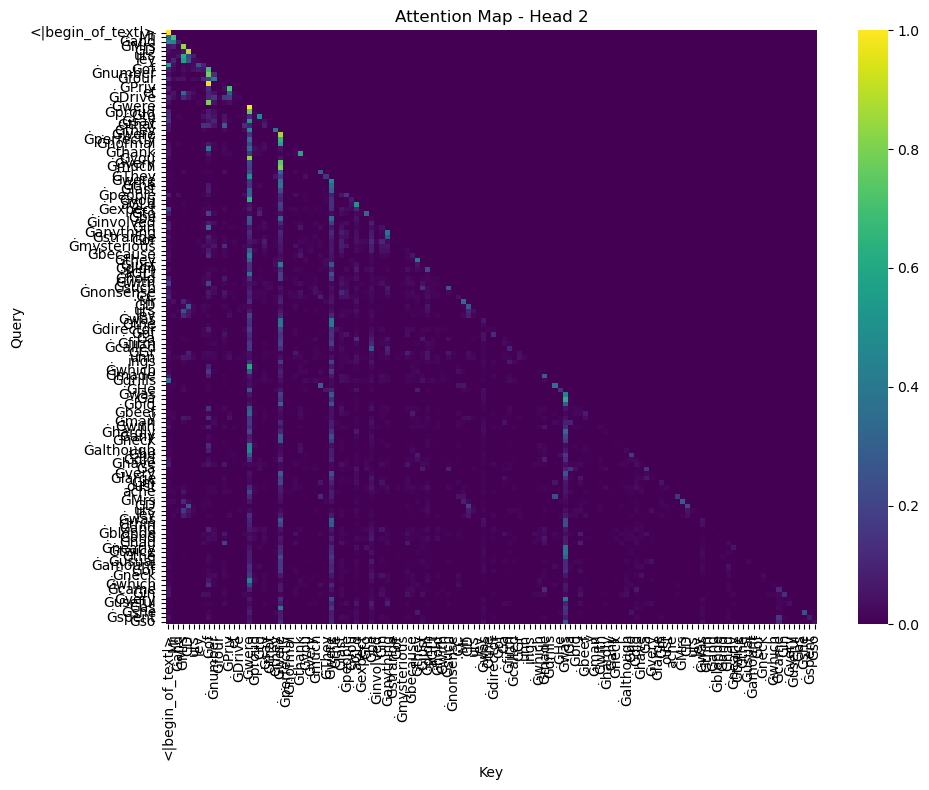

In [35]:
plot_attention_map(attn_scores[0], tokens_str, head=2)


In [36]:
from circuitsvis.attention import attention_patterns

In [37]:
attn_scores = attn_scores[0]  # берем 1-й пример
attn_scores = attn_scores.detach().cpu()

# Приводим к [num_layers, num_heads, seq_len, seq_len]
# В твоем случае возможно только 1 слой → нужно добавить ось
attn_tensor = attn_scores.unsqueeze(0)  # shape: [1, n_heads, seq_len, seq_len]

# Токены
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

In [38]:
attn_tensor = attn_tensor.squeeze(0)
attn_tensor.shape

torch.Size([8, 128, 128])

In [39]:
tokens = [token.replace("Ġ", " ") for token in tokens]
tokens[:10]

['<|begin_of_text|>',
 'Mr',
 ' and',
 ' Mrs',
 ' D',
 'urs',
 'ley',
 ',',
 ' of',
 ' number']

In [40]:
attention_patterns(
    tokens=tokens,
    attention=attn_tensor
)


In [41]:
with torch.no_grad():
    attn1, attn2 = atat_model.get_attention(input_ids.to(atat_model.embed.weight.device), attention_mask.to(atat_model.embed.weight.device))

In [42]:
# Конвертация в нужный формат: [layers, heads, seq, seq]
attn_stack = torch.stack([attn1[0], attn2[0]], dim=0)  # [2, heads, seq, seq]

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
attention_patterns(tokens=tokens, attention=attn_stack.reshape(-1, 128, 128))

In [43]:
def generate_repeated_tokens_from_text(text, tokenizer, device="cuda"):
    tokens = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=64,
    )["input_ids"].to(device)

    bos_token_id = tokenizer.bos_token_id or tokenizer.cls_token_id or tokenizer.pad_token_id or 0
    bos = torch.tensor([[bos_token_id]], device=device)

    repeated = torch.cat([tokens, tokens], dim=-1)[:, :128]  # ensure ≤128
    return repeated


In [44]:
def run_and_cache_model_repeated_tokens(model, tokenizer, text):
    input_ids = generate_repeated_tokens_from_text(text, tokenizer, device=next(model.parameters()).device)
    attention_mask = torch.ones_like(input_ids)

    model.eval()
    with torch.no_grad():
        if hasattr(model, "get_attention"):
            attn = model.get_attention(input_ids, attention_mask)
        else:
            raise ValueError("Модель не имеет метода get_attention()")

        output = model(input_ids, labels=input_ids, attention_mask=attention_mask)
        logits = output["logits"]

    return input_ids, logits, attn


In [45]:
input_ids, logits, attn_layers = run_and_cache_model_repeated_tokens(atat_model, tokenizer, text)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

if isinstance(attn_layers, tuple) or isinstance(attn_layers, list):
    stacked_attn = torch.stack([attn[0] for attn in attn_layers], dim=0)
else:
    stacked_attn = attn_layers  # [1, heads, seq, seq]

In [46]:
stacked_attn.shape

torch.Size([2, 8, 128, 128])

In [47]:
attention_patterns(tokens=tokens, attention=stacked_attn[0, ...])

In [48]:
attention_patterns(tokens=tokens, attention=stacked_attn[1, ...])

In [26]:
conv_weights = coat_model.conv.weight.data.cpu().numpy()
print(conv_weights.shape)  # Ожидается (d_model, d_model, kernel_size)


(512, 512, 3)


In [27]:
# Усредним по оси входных каналов (axis=1), получим матрицу [d_model, kernel_size]
avg_weights = conv_weights.mean(axis=1)


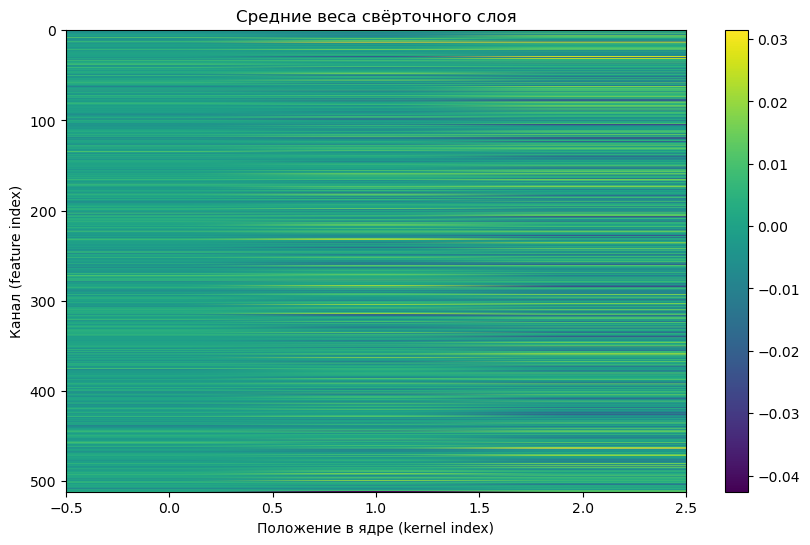

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.imshow(avg_weights, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Средние веса свёрточного слоя")
plt.xlabel("Положение в ядре (kernel index)")
plt.ylabel("Канал (feature index)")
plt.show()


In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def get_subtract_avg_matrix(dim):
    """
    Get a matrix M such that M @ x is the same as x - avg(x).
    Which is the same as zeroing out the diagonal of x.
    """
    # z zeros out diagonal
    z = np.eye(dim) - np.ones((dim, dim)) / dim
    return z


def get_weights_for_head(weights, layer, head, n_heads, d_model, apply_layernorm=True):
    """ Get the weights for a single head. """
    d_head = d_model // n_heads

    w_v = weights[f'b{layer}.attn.in_proj_weight'][2*d_model:]
    w_o = weights[f'b{layer}.attn.out_proj.weight'] 

    w_v_h = w_v[head*d_head: (head+1)*d_head, :]
    w_o_h = w_o[:, head*d_head: (head+1)*d_head]

    w_q = weights[f'b{layer}.attn.in_proj_weight'][:d_model]
    w_k = weights[f'b{layer}.attn.in_proj_weight'][d_model:2*d_model]

    w_q_h = w_q[head*d_head: (head+1)*d_head, :]
    w_k_h = w_k[head*d_head: (head+1)*d_head, :]

    lnw = weights[f'b{layer}.ln.weight'].unsqueeze(1).numpy()
    lnb = weights[f'b{layer}.ln.bias'].unsqueeze(1).numpy()

    p_e = weights[f'b{layer}.pos.pe'].numpy()

    if apply_layernorm:
        # roll layernorm into w_q, w_k, w_v
        M = get_subtract_avg_matrix(d_model)
        w_q_h = w_q_h @ M
        w_q_h = w_q_h * lnw.T

        w_k_h = w_k_h @ M
        w_k_h = w_k_h * lnw.T

        w_v_h = w_v_h @ M
        w_v_h = w_v_h * lnw.T

    return {
        'w_v': w_v_h.numpy(),
        'w_o': w_o_h.numpy(),
        'lnw': lnw,
        'lnb': lnb,
        'w_q': w_q_h.numpy(),
        'w_k': w_k_h.numpy(),
        'p_e': p_e,
    }

def get_embedding_weights(weights, d_model, norm_emb=False, final_layernorm=True):
    """ Get the embedding weights. """

    w_e = weights['embedding.weight'].numpy().T
    if norm_emb:
        lnw = weights['b0.ln.weight'].unsqueeze(1).numpy()
        lnb = weights['b0.ln.bias'].unsqueeze(1).numpy()
        w_e = (w_e - np.average(w_e, axis=0, keepdims=True)) / np.std(w_e, axis=0, keepdims=True)
        w_e = w_e * lnw + lnb
    
    lnfw = weights['ln_f.weight'].unsqueeze(1).numpy()
    lnfb = weights['ln_f.bias'].unsqueeze(1).numpy()

    w_u = weights['unembedding.weight'].numpy()
    if final_layernorm:
        # Roll final layernorm into the unembedding matrix.
        # first we subtract the mean by zeroing out the diagonal dimension.
        M = get_subtract_avg_matrix(d_model)
        w_u = w_u @ M
        # multiply by the layer norm weights
        w_u = w_u * lnfw.T

    return {
        'w_e': w_e,
        'w_u': w_u,
        'lnfw': lnfw,
        'lnfb': lnfb,
    }

def get_ov_eigenvalues(wh, we):
    """
    Get the eigenvalues for the w_u @ w_o @ w_v @ w_e matrix. Equivalent to
    the eigenvalues of the w_v @ w_e @ w_u @ w_o matrix.
    """
    m = wh['w_v'] @ we['w_e'] @ we['w_u'] @ wh['w_o']
    return np.linalg.eigvals(m)

def get_qk_eigenvalues(wh, wh_prev, we):
    """
    eigenvalues of
    w_e w_q w_k w_o w_v w_e
    is equivalent to eigenvalues of
    w_v w_e w_e w_q w_k w_o
    """
    m = wh_prev['w_v'] @ we['w_e'] @ we['w_e'].T @ wh['w_q'].T @ wh['w_k'] @ wh_prev['w_o']
    return np.linalg.eigvals(m)


def positional_attention_for_head(head_weights, plot=False):
    """ compute matrix of preferred relative positions. """
    p_e = head_weights['p_e']
    qk = head_weights['w_q'].T @ head_weights['w_k']

    res = p_e @ qk @ p_e.T

    # mask with zeros
    mask = np.triu(np.ones_like(res), k=1)
    res = res * (1 - mask)

    # to torch, apply softmax, and convert back to numpy
    res = torch.from_numpy(res)
    res = torch.softmax(res, dim=0)
    res = res.numpy()

    # the higher the value, the more the head attends to positions.
    diag_averages = []
    n = res.shape[0]
    for i in range(n):
        diag_averages.append(np.trace(res, offset=-i)/ (n - i*0.99))
    print('positional max: ', np.max(diag_averages))
    print('positional argmax:', np.argmax(diag_averages))
    print('diagonal averages:', diag_averages[:5])

    if plot:
        # plot heatmap of res
        plt.imshow(res)
        plt.show()
    
    return diag_averages


def head_forward_pass(x, weights):
    # x shape is (seq_len, d_model)
    # weights is a dict of weights for the head

    x_pos = x + weights['p_e'][:x.shape[0], :]

    q = weights['w_q'] @ x_pos.T  # q shape is (d_head, seq_len)
    k = weights['w_k'] @ x_pos.T  # k shape is (d_head, seq_len)

    v = weights['w_v'] @ x.T  # v shape is (d_head, seq_len)

    # compute attention
    a = q.T @ k  # a shape is (seq_len, seq_len)
    a = a / np.sqrt(q.shape[0])

    infs = np.full(a.shape, -np.inf)
    mask = np.triu(infs, k=1)
    a = a + mask

    # to torch, softmax, back to numpy haha
    a = torch.from_numpy(a)
    a = torch.softmax(a, dim=1)
    a = a.numpy()

    # compute output
    o = a @ v.T  # o shape is (seq_len, d_head)
    out = o @ weights['w_o'].T  # out shape is (seq_len, d_model)

    return out, a, v.T

In [45]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def k_composition(h_0, h_1):
    """
    Detects k-composition between two heads.

    It looks at the Frobenius norm of the product divided by the norm of the
    individual heads.
    """
    w_ov = h_0['w_o'] @ h_0['w_v']
    w_qk = h_1['w_q'].T @ h_1['w_k']

    f_qkov = np.linalg.norm(w_qk @ w_ov)
    f_qk = np.linalg.norm(w_qk)
    f_ov = np.linalg.norm(w_ov)

    return f_qkov / (f_qk * f_ov)

def q_composition(h_0, h_1):
    """ Detects q-composition between two heads. """
    w_ov = h_0['w_o'] @ h_0['w_v']
    w_qk = h_1['w_q'].T @ h_1['w_k']

    f_qkov = np.linalg.norm(w_qk.T @ w_ov)
    f_qk = np.linalg.norm(w_qk)
    f_ov = np.linalg.norm(w_ov)

    return f_qkov / (f_qk * f_ov)

def v_composition(h_0, h_1):
    """ Detects v-composition between two heads. """
    w_ov_0 = h_0['w_o'] @ h_0['w_v']
    w_ov_1 = h_1['w_o'] @ h_1['w_v']

    f_ovov = np.linalg.norm(w_ov_0 @ w_ov_1)
    f_ov_0 = np.linalg.norm(w_ov_0)
    f_ov_1 = np.linalg.norm(w_ov_1)

    return f_ovov / (f_ov_0 * f_ov_1)

def compute_qkv_composition(weights, n_heads, d_model):
    pos = []
    for h in range(n_heads):
        print()
        print('layer 0, head', h)
        h_w = get_weights_for_head(weights, layer=0, head=h,
            n_heads=n_heads, d_model=d_model, apply_layernorm=False)
        avg = positional_attention_for_head(h_w, plot=False)

        pos.append(avg[1]) # previous token

    k_comp = np.zeros((n_heads, n_heads))
    q_comp = np.zeros((n_heads, n_heads))
    v_comp = np.zeros((n_heads, n_heads))
    for h0 in range(n_heads):
        for h1 in range(n_heads):
            h_w_0 = get_weights_for_head(weights, layer=0, head=h0, n_heads=n_heads, d_model=d_model)
            h_w_1 = get_weights_for_head(weights, layer=1, head=h1, n_heads=n_heads, d_model=d_model)
            k_comp[h0, h1] = k_composition(h_0=h_w_0, h_1=h_w_1)
            q_comp[h0, h1] = q_composition(h_0=h_w_0, h_1=h_w_1)
            v_comp[h0, h1] = v_composition(h_0=h_w_0, h_1=h_w_1)

    # print(k_comp)

    vmin = min(q_comp.min(), k_comp.min(), v_comp.min())
    vmax = max(q_comp.max(), k_comp.max(), v_comp.max())

    # fig = plt.figure(figsize=(40, 5))
    # gs = GridSpec(1, 4, width_ratios=[10, 10, 10, 4])
    fig = plt.figure(figsize=(30, 5))
    gs = GridSpec(1, 4, width_ratios=[12, 12, 12, 1])

    ax1 = fig.add_subplot(gs[0])
    im1 = ax1.imshow(q_comp, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_ylabel('Layer 0 Heads')
    ax1.set_xlabel('Layer 1 Heads')
    ax1.set_title('Q-Composition')

    ax2 = fig.add_subplot(gs[1])
    im2 = ax2.imshow(k_comp, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_ylabel('Layer 0 Heads')
    ax2.set_xlabel('Layer 1 Heads')
    ax2.set_title('K-Composition')

    ax3 = fig.add_subplot(gs[2])
    im3 = ax3.imshow(v_comp, cmap='viridis', vmin=vmin, vmax=vmax)
    ax3.set_ylabel('Layer 0 Heads')
    ax3.set_xlabel('Layer 1 Heads')
    ax3.set_title('V-Composition')

    # Add the subplot on the right for the nx1 matrix
    ax4 = fig.add_subplot(gs[3])
    im4 = ax4.imshow(np.array(pos).reshape(-1, 1), cmap='viridis')#, aspect='auto')
    ax4.set_ylabel('Layer 0 Heads')
    ax4.set_title('prev tok heads')

    ax4.set_xticks([])
    # ax2.set_yticks([])

    # Show the plot
    plt.show()


def get_attention(weights, tokens, n_heads, d_model):
    """ Forward pass, return attention and value norms. """

    tokens = [50257] + tokens  # add start token

    layer_0 = []
    for h in range(n_heads):
        layer_0.append(get_weights_for_head(weights,
                                            layer=0,
                                            head=h,
                                            n_heads=n_heads,
                                            d_model=d_model,
                                            apply_layernorm=False,
                                            ))
    layer_1 = []
    for h in range(n_heads):
        layer_1.append(get_weights_for_head(weights,
                                            layer=1,
                                            head=h,
                                            n_heads=n_heads,
                                            d_model=d_model,
                                            apply_layernorm=False,
                                            ))
    
    x = weights['embedding.weight'].numpy()[tokens, :]

    x_ln = (x - np.mean(x, axis=-1, keepdims=True)) / (np.std(x, axis=-1, keepdims=True) + 1e-5)
    x_ln = x_ln * weights['b0.ln.weight'].numpy() + weights['b0.ln.bias'].numpy()

    layer_0_res = []
    for h in range(n_heads):
        layer_0_res.append(head_forward_pass(x_ln, layer_0[h]))
    
    for h in range(n_heads):
        x += layer_0_res[h][0]
    
    x_ln = (x - np.mean(x, axis=-1, keepdims=True)) / (np.std(x, axis=-1, keepdims=True) + 1e-5)
    x_ln = x_ln * weights['b1.ln.weight'].numpy() + weights['b1.ln.bias'].numpy()

    layer_1_res = []
    for h in range(n_heads):
        layer_1_res.append(head_forward_pass(x_ln, layer_1[h]))
    
    for h in range(n_heads):
        x += layer_1_res[h][0]
    
    attention = [out[1] for out in layer_0_res] + [out[1] for out in layer_1_res]
    attention = np.array(attention)
    attention = np.transpose(attention, (1, 2, 0))

    value_norms = [out[2] for out in layer_0_res] + [out[2] for out in layer_1_res]
    value_norms = [np.linalg.norm(v, axis=-1) for v in value_norms]
    value_norms = np.array(value_norms)
    value_norms = value_norms.T

    weighted_attn = np.zeros_like(attention)
    for i in range(attention.shape[0]):
        weighted_attn[i] = attention[i] * value_norms
        weighted_attn[i] /= np.max(weighted_attn[i])

    return weighted_attn

def compute_eigenvalue_positivity(weights, n_heads, d_model):
    layer_0 = []
    for h in range(n_heads):
        layer_0.append(get_weights_for_head(weights,
                                            layer=0,
                                            head=h,
                                            n_heads=n_heads,
                                            d_model=d_model,
                                            apply_layernorm=True,
                                            ))
    layer_1 = []
    for h in range(n_heads):
        layer_1.append(get_weights_for_head(weights,
                                            layer=1,
                                            head=h,
                                            n_heads=n_heads,
                                            d_model=d_model,
                                            apply_layernorm=True,
                                            ))
    embedding_weights = get_embedding_weights(weights, d_model=d_model,
                                              norm_emb=False, final_layernorm=True)
    
    # ov positivity
    ov_eigen_pos = []
    for h in range(n_heads):
        ov_eigen = get_ov_eigenvalues(wh=layer_1[h], we=embedding_weights)
        r = ov_eigen.real
        norms = []
        for i in range(ov_eigen.shape[0]):
            norms.append(np.linalg.norm(ov_eigen[i]))
        ov_eigen_pos.append(np.sum(r) / np.sum(norms))
    
    # qk positivity
    previous_token_head = 11 # We know l_0_h_11 is the previous token head
    qk_eigen_pos = []
    for h in range(n_heads):
        qk_eigen = get_qk_eigenvalues(wh=layer_1[h],
                                      wh_prev=layer_0[previous_token_head],
                                      we=embedding_weights)
        r = qk_eigen.real
        norms = []
        for i in range(qk_eigen.shape[0]):
            norms.append(np.linalg.norm(qk_eigen[i]))
        qk_eigen_pos.append(np.sum(r) / np.sum(norms))
    
    # We color the heads that we've previously identified as induction heads
    colors = ['grey'] * 12
    colors[3] = 'turquoise'
    colors[7] = 'turquoise'
    colors[9] = 'turquoise'

    # plot qk vs ov
    plt.scatter(ov_eigen_pos, qk_eigen_pos, c=colors)
    plt.title("Second Layer Attention Heads by OV and QK Eigenvalue Positivity")
    plt.xlabel("OV positivity")
    plt.ylabel("QK positivity")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()


def plot_attention_on_text(encoder, weights, n_heads, d_model):
    """ Plot attention on text. """

    # requires https://github.com/anthropics/PySvelte
    import pysvelte

    toks = encoder.encode(
        "Mr and Mrs Dursley, of number four, Privet Drive, were proud to say " + \
        "that they were perfectly normal, thank you very much. They were the " + \
        "last people you'd expect to be involved in anything strange or " + \
        "mysterious, because they just didn't hold with such nonsense. Mr Dursley " + \
        "was the director of a firm called Grunnings, which made drills. He was a " + \
        "big, beefy man with hardly any neck, although he did have a very large " + \
        "moustache. Mrs Dursley was thin and blonde"
    )
    words = ["<START>"] + [encoder.decode([t]) for t in toks]
    attn = get_attention(weights, toks, n_heads, d_model)

    pysvelte.AttentionMulti(tokens=words, attention=attn,
                            head_labels=['0:0', '0:1', '0:2', '0:3', '0:4', '0:5',
                                         '0:6', '0:7', '0:8', '0:9', '0:10', '0:11',
                                         '1:0', '1:1', '1:2', '1:3', '1:4', '1:5',
                                         '1:6', '1:7', '1:8', '1:9', '1:10', '1:11'],
                            ).publish("./potter.html")


# if __name__=='__main__':
#     enc = tiktoken.get_encoding("gpt2")

#     weights = torch.load("../from_odin/big_2layer_long_108000.pt", map_location='cpu')

#     for weight in weights:
#         print(weight, weights[weight].shape)

#     config = get_config()
#     n_heads = config.model.n_head
#     d_model = config.model.n_embd

#     compute_qkv_composition(weights, n_heads, d_model)
#     # plot_attention_on_text(encoder=enc, weights=weights, n_heads=n_heads, d_model=d_model)

#     compute_eigenvalue_positivity(weights, n_heads, d_model)

In [41]:
def convert_my_weights(state_dict):
    converted = {}

    # Слой 0
    w_q = state_dict['attn1.w_q.weight']
    w_k = state_dict['attn1.w_k.weight']
    w_v = state_dict['attn1.w_v.weight']
    converted['b0.attn.in_proj_weight'] = torch.cat([w_q, w_k, w_v], dim=0)
    converted['b0.attn.out_proj.weight'] = state_dict['attn1.w_o.weight']

    # Слой 1
    w_q = state_dict['attn2.w_q.weight']
    w_k = state_dict['attn2.w_k.weight']
    w_v = state_dict['attn2.w_v.weight']
    converted['b1.attn.in_proj_weight'] = torch.cat([w_q, w_k, w_v], dim=0)
    converted['b1.attn.out_proj.weight'] = state_dict['attn2.w_o.weight']

    # Embedding & unembedding
    converted['embedding.weight'] = state_dict['embed.weight']
    converted['unembedding.weight'] = state_dict['unembed.weight']

    # Фиктивные layernorm и позиционные энкодинги
    d_model = state_dict['embed.weight'].shape[1]
    converted['b0.ln.weight'] = torch.ones(d_model)
    converted['b0.ln.bias'] = torch.zeros(d_model)
    converted['b1.ln.weight'] = torch.ones(d_model)
    converted['b1.ln.bias'] = torch.zeros(d_model)
    converted['ln_f.weight'] = torch.ones(d_model)
    converted['ln_f.bias'] = torch.zeros(d_model)
    converted['b0.pos.pe'] = torch.zeros(128, d_model)  # 128 — максимальная длина

    return converted


In [42]:
from safetensors.torch import load_file

state_dict = load_file("at-at-pretrain-owt/checkpoint-493347/model.safetensors")
weights = convert_my_weights(state_dict)

In [48]:
attn1.shape

torch.Size([1, 8, 128, 128])

In [50]:
attn1.squeeze(0)[0, ...]

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9916, 0.0084, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9841, 0.0082, 0.0077,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4712, 0.0040, 0.0038,  ..., 0.0026, 0.0000, 0.0000],
        [0.4727, 0.0039, 0.0037,  ..., 0.0026, 0.0032, 0.0000],
        [0.4692, 0.0040, 0.0038,  ..., 0.0026, 0.0032, 0.0018]],
       device='cuda:0')

In [51]:
attn1.squeeze(0)[1, ...]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.7162e-01, 2.8381e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.9937e-01, 1.0613e-04, 5.1918e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.0521e-01, 5.0988e-04, 3.1439e-03,  ..., 2.6019e-04, 0.0000e+00,
         0.0000e+00],
        [2.4154e-04, 1.2287e-03, 7.7229e-03,  ..., 6.3785e-04, 1.1056e-03,
         0.0000e+00],
        [3.1594e-04, 2.2407e-05, 6.1001e-07,  ..., 1.2152e-04, 2.7083e-05,
         3.3700e-04]], device='cuda:0')

In [46]:
# теперь можно использовать:
compute_qkv_composition(weights, n_heads=8, d_model=512)


layer 0, head 0
positional max:  0.0078125
positional argmax: 0
diagonal averages: [0.0078125, 0.007811884890953468, 0.007811260117441677, 0.007810625449892026, 0.007809980651402773]

layer 0, head 1
positional max:  0.0078125
positional argmax: 0
diagonal averages: [0.0078125, 0.007811884890953468, 0.007811260117441677, 0.007810625449892026, 0.007809980651402773]

layer 0, head 2
positional max:  0.0078125
positional argmax: 0
diagonal averages: [0.0078125, 0.007811884890953468, 0.007811260117441677, 0.007810625449892026, 0.007809980651402773]

layer 0, head 3
positional max:  0.0078125
positional argmax: 0
diagonal averages: [0.0078125, 0.007811884890953468, 0.007811260117441677, 0.007810625449892026, 0.007809980651402773]

layer 0, head 4
positional max:  0.0078125
positional argmax: 0
diagonal averages: [0.0078125, 0.007811884890953468, 0.007811260117441677, 0.007810625449892026, 0.007809980651402773]

layer 0, head 5
positional max:  0.0078125
positional argmax: 0
diagonal averag

KeyError: 'b1.pos.pe'